# Langchain Tools & Agents

## What you will learn in this course? 🧐🧐

Generating text is pretty powerful but it becomes really impressive when actions are triggered based on what was generated 😉 This is called **Agents**. These are actionable python functions that will know what actions are expected based on what an LLM generated. Combined with Langchain **Tools** it becomes really powerful because you will be able to run internet searches, use a code interpreter etc. In this course, you will learn:

- LangGraph node and edges
- Langchain tools
- How to create simple and start-of-the-art agents


<Note type="important">

If you want to follow along, again use:

```bash
docker run -v $(pwd):/home/jovyan -p 8888:8888 jupyter/datascience-notebook
```

You will have a Jupyter Notebook ready to use

</Note>


In [1]:
# If that's not the case, don't forget to install the following libraries
!pip install langchain -q
!pip install langchain-community -q 
!pip install langchain_mistralai -q
!pip install langserve -q
!pip install langgraph -q
!pip install transformers -q
!pip install rizaio -q 
!pip install --upgrade typing_extensions -q # If you have errors like "cannot import name 'ReadOnly' from 'typing_extensions'" DON'T FORGET TO RESTART YOUR KERNEL

In [3]:
# Set your Mistral API key 
#%env MISTRAL_API_KEY=

# Demo app 🎮

For this course, we will aim to build a chatbot that includes a **code interpreter**. This would make a perfect developer assistant! Let's see how we can set it up. First, let's have some basic code template:


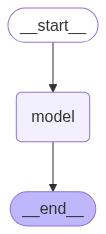

In [56]:
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langchain_core.messages import SystemMessage
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import START, MessagesState, StateGraph
from langchain_mistralai import ChatMistralAI

from IPython.display import Image, display
from langchain_core.runnables.graph import MermaidDrawMethod

# Create our LLM
llm = ChatMistralAI(model="ministral-8b-latest")

# LangGraph uses the concepts of graphs which corresponds to a workflow
# The first thing you need to do is to instanciate that graph using StateGraph.
# StateGraph needs to be provided a schema meaning the data it is expected to handle that is called states
# A State corresponds to the data stored at a given moment in your graph as well as functions (called "reducers")
# which purpose is to update the State.
# In our case, we use MessagesState which is pre-configured State meant for messages
workflow = StateGraph(state_schema=MessagesState)


# Let's create a simple model with a system prompt
def call_model(state: MessagesState):
    # Intanciate the system prompt
    start_prompt = ChatPromptTemplate.from_messages(
        [
            SystemMessage(
                content="You are a protocol droid designed for assisting sentient beings in writing code."
            ),
            MessagesPlaceholder(
                "messages"
            ),  # This is where the additional messages will be added
        ]
    )

    # Chain the system prompt with Mistral LLM model
    model = start_prompt | llm

    # Here we need to provide a dictionnary with all the messages
    response = model.invoke({"messages": state["messages"]})
    return {"messages": response}


# This part defines a single node and an edge
# an Edge is simply the "how" we get from one node to the other one
# I like LangGraph short definition: "nodes do the work. edges tell what to do next."
workflow.add_edge(START, "model")
workflow.add_node("model", call_model)

# This is stored in RAM of the computer.
# This is not ideal for production and large conversation history where you will need to define a PostgreSQL DB (more on the later on)
memory = MemorySaver()

# Store the whole graph
app = workflow.compile(checkpointer=memory)


# Display our current graph's schema
display(
    Image(
        app.get_graph().draw_mermaid_png(
            draw_method=MermaidDrawMethod.API,
        )
    )
)

As you can see, this is the exact same code as in the previous lecture where we have:

- One "start" node
- One edge going from start to "model" node
- One "model" node that holds our chatbot

Let's create a basic interaction to verify that everything works:


In [57]:
from langchain_core.messages import HumanMessage

# Configure a thread
config = {"configurable": {"thread_id": "abc123"}}

# Simply query
query = "Can you tell me what is 3+5 using Python?"

# Parse the message into an acceptable data type for our model. In our case, the model accepts list of messages
input_messages = [HumanMessage(query)]

# Now the new element when calling ".invoke()" is to add a config parameter to add the memory
output = app.invoke({"messages": input_messages}, config)

output["messages"][
    -1
].pretty_print()  # output contains all messages in state so we take only the last one

================================== Ai Message ==================================

Certainly! In Python, you can perform arithmetic operations using the `+` operator. Here is how you can calculate `3 + 5`:

```python
result = 3 + 5
print(result)
```

When you run this code, it will output:

```
8
```

So, `3 + 5` equals `8` in Python.


## Integrate Tools in our application

Many AI applications interact directly with humans. In these cases, it is appropriate for models to respond in natural language. But what about cases where we want a model to also interact directly with systems, such as databases or an API? These systems often have a particular input schema; for example, APIs frequently have a required payload structure. This need motivates the concept of tool calling. You can use tool calling to request model responses that match a particular schema.

Here's a schema taken from langchain's documentation to illustrate how tools work:

![tools](https://full-stack-assets.s3.eu-west-3.amazonaws.com/images/M10-llm/tool_calling_components-bef9d2bcb9d3706c2fe58b57bf8ccb60.png)


In [58]:
def multiply(a: int, b: int) -> int:
    """Multiply a and b.

    Args:
        a: first int
        b: second int
    """
    return a * b


llm_with_tools = llm.bind_tools([multiply])
result1 = llm_with_tools.invoke("Hello world!")
result1.pretty_print()
print(result1.tool_calls)
result2 = llm_with_tools.invoke("What is 2 multiplied by 3?")
result2.pretty_print()
print(result2.tool_calls)

================================== Ai Message ==================================

Hello! How can I assist you today?
[]
================================== Ai Message ==================================
Tool Calls:
  multiply (hAwYuFd8K)
 Call ID: hAwYuFd8K
  Args:
    a: 2
    b: 3
[{'name': 'multiply', 'args': {'a': 2, 'b': 3}, 'id': 'hAwYuFd8K', 'type': 'tool_call'}]


In this example, the model understands that we ask it to perform a mathematic operation, it detects inputs a, and b, and uses the provided tool instead of relying solely on its NLP capabilities.


### Tool for code execution

Alright let's spice it up a little bit 🌶️ Now we want to add code interpreter that is able to actually run python code. To do se we will be using a [LangChain integrated tool]() called Riza

Now the first action we need to do is to:

- [Create an account on Riza](https://riza.io/) - This is a code interpreter tool
  - This is completely free and the cool thing is that you can self host the code interpreter 🤗

<Note type="important" title="Riza is limited as of today">

For this course we chose to have a free tool to play with. However, this is pretty new technology so there are a lot development going on and limitations.

So far we know that:

- Riza **cannot integrate pandas** as library

If you are looking to implement a 100% robust code interpreter, you will need to either:

- Build it yourself
- Use a paid tool like [Azure Container Apps dynamic sessions](https://python.langchain.com/docs/integrations/tools/azure_dynamic_sessions/)

</Note>

<Note type="warning" title="Tool usage is model dependent">

The model will decide whether to use the provided tools or not. For instance most light weight models have rather simplistic or unpredictable behavior. If the tools you provided are ignored when you thought they should not be, switch to a more complex model.

Example: switch from `"mistral-small-latest"` to `"mistral-large-latest"`

</Note>

Once you created your account, get your API key and set it up as environment variable:


In [11]:
# Get your API key directly here: https://dashboard.riza.io/
#%env RIZA_API_KEY=

Perfect, now we can use LangChain tools to create awesome AI applications! To do so we need to:

- Create and integrate a tool within our ChatModel
- Then create an agent that will know when to use the tool or just leave that way.

Let's tackle the first part:


In [59]:
# Let's import ExecPython which is the class used to execute python code with Riza
from langchain_community.tools.riza.command import ExecPython

llm = ChatMistralAI(
    model="mistral-large-latest"
)  # You can use whatever chat model you want here

tools = [
    ExecPython()
]  # Let's intanciate ExecPython and it needs to be an item of a list
powered_llm = llm.bind_tools(
    tools
)  # Integrate the tool within our LLm via bind_tools() method. Again careful, this methods accepts lists only (even if you have one tool)

# Now lets use our tool!
# Now given the prompt you write, the model will decide whether it's a good idea or not to "call" the tool
# You can verify that the tool has been called by using .tool_calls attribute
# Careful .tool_calls is not always available for all chat models.
# It will be for any models that follow the OpenAI api structure of their model (Mistral does)
result = powered_llm.invoke(
    "Execute this python code: ```python import pandas as pd```"
)

print(result.tool_calls)
result.pretty_print()

[{'name': 'riza_exec_python', 'args': {'code': 'import pandas as pd'}, 'id': 'q1IozdcVC', 'type': 'tool_call'}]
================================== Ai Message ==================================
Tool Calls:
  riza_exec_python (q1IozdcVC)
 Call ID: q1IozdcVC
  Args:
    code: import pandas as pd


Perfect as you can see, with `.bind_tools()` method we can integrate a tool within our LLM. Now for every prompt sent to the model, it will determine whether to call the tool or not.

If you want to verify that a tool has been called, you can use `.tool_calls`.

<Note type="note">

Careful `.tool_calls` is not always available for all chat models.
It will be for any models that follow the OpenAI api structure of their model (Mistral does)

</Note>

<Note type="tip" title="Still don't understand what tools are">

Think of tools as python functions (which they actually are). The only "weird" thing is that calling the tool is not always certain.

For example, one model will want to call the code interpreter tool for any python code it sees (this will often be the case for small models). However, some other models (bigger ones like Codestral) will be able to interpret simple code on their own.

For example if you ask Codestral to `print(3+4)` using Python, it won't even try to call a code interpreter because it will already know the answer.

</Note>

## Add logic with LangGraph Agents

Now that we understand how tools work. We need to integrate some kind of logic (i.e we need to tell our application what to do when our model wants to call our tool). To do so, we'll push further our knowledge of LangGraph and Agents.

<Note type="note" title="Agents & LangGraph, what is the difference?">

Agents is an old terminology in the LangGraph vocabulary. If you stick to everything LangChain-related, you will read the term _Graph_ instead of _Agents_. The reason is because LangGraph designed agents to work as a graph (with nodes and edges.).

However outside of LangChain, the term _Agents_ ise widely used. Both agent, and graph designate the same thing though:

- Providing a logic and actions to your LLM application (like interpreting code)

</Note>

Now let's create our Agent and look deeper into our logic:


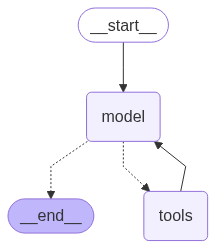

In [60]:
from langgraph.prebuilt import ToolNode, tools_condition

# You already know that part
llm = ChatMistralAI(model="mistral-large-latest")
## Bind tool
tool = [ExecPython()]
powered_llm = llm.bind_tools(tool)

# Create a graph
workflow = StateGraph(state_schema=MessagesState)


# Integrate our prompts
def call_model(state: MessagesState):
    start_prompt = ChatPromptTemplate.from_messages(
        [
            SystemMessage(
                content="You are a protocol droid designed for assisting sentient beings in writing code."
            ),
            MessagesPlaceholder(
                "messages"
            ),  # This is where the additional messages will be added
        ]
    )

    model = start_prompt | powered_llm
    response = model.invoke({"messages": state["messages"]})

    return {"messages": response}


# THIS IS NEW 👋
# Here we will be using the `ToolNode` class to build the node that uses the tool we set above
# The ToolNode class is extremely useful because it's an abstraction layer that takes care of the
# Node logic for us. However, you could have created your own custom logic. If you want to see how to do it
# Feel free to read more here: https://langchain-ai.github.io/langgraph/tutorials/introduction/#part-2-enhancing-the-chatbot-with-tools
tool_node = ToolNode(tools=tool)

workflow.add_edge(START, "model")
workflow.add_node("model", call_model)

# Here we just add another node into our graph.
# Careful not to confuse ToolNode that builds the Node logic (python function basically that will handle the "what to do")
# with the .add_node() which adds the node to our current graph
workflow.add_node("tools", tool_node)

# THIS IS NEW 👋
# Here we will add a conditional edge.
# This means that the graph will follow this edge ONLY if the model has called the tool
# If .tool_calls attribute is not empty then we will go to the tool node
# Otherwise graph will simply stay at the "model" node
workflow.add_conditional_edges(
    "model",
    tools_condition,  # This is a pre-built python function that makes the graph go to the ToolNode if .tool_calls is not empty (more here: https://langchain-ai.github.io/langgraph/reference/prebuilt/#langgraph.prebuilt.tool_node.InjectedStore)
)

workflow.add_edge("tools", "model")

# You already know below
memory = MemorySaver()

app = workflow.compile(checkpointer=memory)

display(
    Image(
        app.get_graph().draw_mermaid_png(
            draw_method=MermaidDrawMethod.API,
        )
    )
)

As you can see now our graph is a bit more complex. Now instead of just having a _model_ node, we have an additional _tools_ node that will be called whenever our model outputs messages containing the `.tool_calls` attribute. If that's the case then, the Riza code interpreter will be called.

Let's try it now:


In [61]:
from langchain_core.messages import HumanMessage

# Configure a new thread
config = {"configurable": {"thread_id": "39500"}}

# Query that includes python code:
query = """
Execute the code below:

```
import random

# Set the length of the list
list_length = 10

# Create an empty list
random_list = []

# Fill the list with random integers between 0 and 100
for i in range(list_length):
    random_list.append(random.randint(0, 100))

# Print the list
print(random_list)
```
"""

input_messages = [HumanMessage(query)]

output = app.invoke({"messages": input_messages}, config)
output  # Let's just output the raw content to see every step of the workflow

{'messages': [HumanMessage(content='\nExecute the code below:\n\n```\nimport random\n\n# Set the length of the list\nlist_length = 10\n\n# Create an empty list\nrandom_list = []\n\n# Fill the list with random integers between 0 and 100\nfor i in range(list_length):\n    random_list.append(random.randint(0, 100))\n\n# Print the list\nprint(random_list)\n```\n', additional_kwargs={}, response_metadata={}, id='435bbda6-fc9e-4730-9cc5-696872a37dd7'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'rmXJYFWtw', 'function': {'name': 'riza_exec_python', 'arguments': '{"code": "import random\\n\\n# Set the length of the list\\nlist_length = 10\\n\\n# Create an empty list\\nrandom_list = []\\n\\n# Fill the list with random integers between 0 and 100\\nfor i in range(list_length):\\n    random_list.append(random.randint(0, 100))\\n\\n# Print the list\\nprint(random_list)"}'}, 'index': 0}]}, response_metadata={'token_usage': {'prompt_tokens': 242, 'total_tokens': 371, 'completion

Yay! 😻 You can see four messages:

1. The human message containing the `query`
2. Then the first answer from model that has `tool_calls` attribute
3. Therefore graph went to the _tools_ node and that is why we have a `ToolMessage` response that only gives us the python code output
4. The final AI answer with the answer we want

It means that everything worked well, that's awesome! 🥳


## Tools you can use 🧰

So far we've shown you only one tool but the great thing about LangChain is that it integrates a lot of different tools. Among them are:

| Tools             | Description                                 |
| ----------------- | ------------------------------------------- |
| Search            | These tools are made to search the web      |
| Code interpreters | To execute python code                      |
| Productivity      | Use to automate tasks (like sending emails) |
| Web browsing      | To simulate a web browser                   |
| Databases         | Interact with SQL or NoSQL DB               |

If you want to have the whole list, you can definitely checkout Langchain whole documentation here:

- [Tools / Toolkit](https://python.langchain.com/docs/integrations/tools/)


## More advanced usage of tools 💪

The cool thing with the above approach is that it is relatively simple but... it's not really flexible. As your application grows in complexity, you will want to have more control over your agents. When that is the case, you can create custom tools by writing normal python functions and add the `@tool` decorator before your function.

Let's take back our code interpreter example. So far our code interpreter doesn't have any library installed apart from the built-in ones which makes it pretty limited. Therefore, one thing that we could to do is to add the following feature:

- A custom runtime (with `numpy` installed) to run basic statistics

<Note type="important" title="Before running this demo">

For the below demo to work, you need to create a custom runtime on your Riza dashboard:

- Go on your dashboard
- Click on Custom Runtimes
- Then create a custom runtime

More details here 👉 [Custom Runtimes](https://docs.riza.io/guides/custom-runtimes)

</Note>

Let's see how we can work things out:


In [86]:
from rizaio import Riza
from langchain_core.runnables import RunnableConfig
from langchain_core.tools import tool

# Initialize the Riza client (done globally to avoid reinitializing it on each call)
client = Riza()


# Define a custom tool for executing Python code with Riza
@tool

# the RunnableConfig are configurable parameters that we can use
# when running app.invoke(). We actually did it when using adding memory feature
# This time the idea is to have app.invoke("message": message, config: {"configurable": "thread_id": "abc123", "runtime": "runtime_value_for_riza"})
def exec_python_riza(code: str, config: RunnableConfig) -> dict:
    """Execute Python code using a custom Riza runtime from RunnableConfig."""  # 🚨 This is called docstrings and they are mandatory

    # Extract the runtime from the config
    runtime = config["configurable"]["runtime"]

    # Execute the code using the Riza client
    # This comes from Riza's documentation
    response = client.command.exec(
        runtime_revision_id=runtime,  # Use the runtime from config
        language="python",
        code=code,  # Execute the provided code
    )

    return dict(response)

As you can see, we defined a normal python function `exec_python_riza`. The only thing we added was that `@tool` decorator.

<Note type="note" title="How did you know to use that client.command.exec?">

Now with greater controls comes more necessary knowledge about the tool you are using. If you are wondering how did I know to use `client.command.exec()` method, [I actually read Riza's direct documentation](https://docs.riza.io/introduction) which is where the code comes from.

So not only you will need to know about Langchain but also about the tools you integrate to it. This is always the difficult part of added flexibility 🤷‍♀️

</Note>

Other than this, the whole process of defining the graph stays the same:


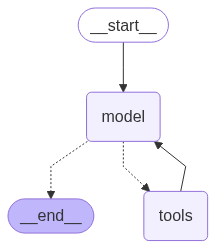

In [87]:
# Define the LangGraph workflow
workflow = StateGraph(state_schema=MessagesState)

# Instantiate the LLM (ChatMistralAI)
llm = ChatMistralAI(model="mistral-large-latest")

# Bind the custom tool (exec_python_riza) to the LLM
powered_llm = llm.bind_tools([exec_python_riza])


# Define a model call with a system prompt
def call_model(state: MessagesState):
    start_prompt = ChatPromptTemplate.from_messages(
        [
            SystemMessage(
                content="You are a Python code interpreter assistant. When you see python code, you should call available tools at your disposal!"
            ),
            MessagesPlaceholder("messages"),
        ]
    )
    model = start_prompt | powered_llm
    response = model.invoke({"messages": state["messages"]})
    return {"messages": response}


# Add nodes and edges to the workflow
workflow.add_edge(START, "model")
workflow.add_node("model", call_model)
workflow.add_node(
    "tools", ToolNode(tools=[exec_python_riza])
)  # 👋 Here we just changed the tool
workflow.add_conditional_edges("model", tools_condition)
workflow.add_edge("tools", "model")

# Manage state in memory and compile the workflow
memory = MemorySaver()
app = workflow.compile(checkpointer=memory)

# Display our current graph's schema
display(
    Image(
        app.get_graph().draw_mermaid_png(
            draw_method=MermaidDrawMethod.API,
        )
    )
)

In [88]:
# Configure a thread
# 👋 THIS IS NEW
config = {
    "configurable": {
        "thread_id": "3896",
        "runtime": "01JV9WVCNKPTGSFCRYGH7S1EHV",  # As you can see, we added the runtime parameter in the configurables
    }
}


# Fun star wars program using Numpy
query = """
Execute the code below:

```python
import numpy as np

# Define starting health points (HP) for Luke and Vader
luke_hp = 100
vader_hp = 100

# Define the damage each attack can deal (a random value between 5 and 20)
def attack():
    return np.random.randint(5, 21)

# Simulate a lightsaber duel until one of them loses
round_num = 1
while luke_hp > 0 and vader_hp > 0:
    print(f"Round {round_num}:")
    
    # Luke attacks Vader
    damage_to_vader = attack()
    vader_hp -= damage_to_vader
    print(f"Luke swings his lightsaber! Vader takes {damage_to_vader} damage. Vader's HP: {vader_hp}")
    
    if vader_hp <= 0:
        print("Vader has been defeated! Luke is victorious!")
        break

    # Vader attacks Luke
    damage_to_luke = attack()
    luke_hp -= damage_to_luke
    print(f"Vader strikes back! Luke takes {damage_to_luke} damage. Luke's HP: {luke_hp}")
    
    if luke_hp <= 0:
        print("Luke has been defeated! Vader wins!")
        break
    
    round_num += 1
    print("-" * 30)

if luke_hp > 0:
    print("The Force is strong with Luke!")
else:
    print("The Dark Side prevails...")
```
"""


# This functions sanitize the code to make sure that the code interpreter doesn't
# misinterpret indentations etc.
# YOU DON'T HAVE TO IMPLEMENT IT THIS IS NOT NECESSARY FOR THE GLOBAL AI APP
# However if you remove it, you won't be able to run complex code like the one above
def sanitize_code(code: str) -> str:
    """Sanitize the code by properly indenting and escaping characters."""
    # Strip extra spaces and normalize indentation
    sanitized_code = code.strip()

    # Replace problematic characters (like tabs or special characters) if needed
    sanitized_code = sanitized_code.replace("\t", "    ")  # Replace tabs with 4 spaces

    # Ensure newline characters are properly handled
    sanitized_code = sanitized_code.replace("\n", "\\n").replace('"', '\\"')

    return sanitized_code


# Sanitize the code before passing it to the tool
sanitized_query = sanitize_code(query)

# Parse the message into an acceptable data type for our model. In our case, the model accepts list of messages
input_messages = [HumanMessage(sanitized_query)]

# Now the new element when calling ".invoke()" is to add a config parameter to add the memory
# You will need to replace jedha/jedha-project-1/data-science@01JAB1C7M090FWQ3PAWA52SYHW by your own runtime
output = app.invoke({"messages": input_messages}, config)

output["messages"][
    -1
].pretty_print()  # output contains all messages in state so we take only the last one

================================== Ai Message ==================================

Here is the output of the lightsaber duel between Luke and Vader:

```
Round 1:
Luke swings his lightsaber! Vader takes 17 damage. Vader's HP: 83
Vader strikes back! Luke takes 13 damage. Luke's HP: 87
------------------------------
Round 2:
Luke swings his lightsaber! Vader takes 17 damage. Vader's HP: 66
Vader strikes back! Luke takes 12 damage. Luke's HP: 75
------------------------------
Round 3:
Luke swings his lightsaber! Vader takes 18 damage. Vader's HP: 48
Vader strikes back! Luke takes 5 damage. Luke's HP: 70
------------------------------
Round 4:
Luke swings his lightsaber! Vader takes 10 damage. Vader's HP: 38
Vader strikes back! Luke takes 15 damage. Luke's HP: 55
------------------------------
Round 5:
Luke swings his lightsaber! Vader takes 19 damage. Vader's HP: 19
Vader strikes back! Luke takes 6 damage. Luke's HP: 49
------------------------------
Round 6:
Luke swings his lightsaber! Va

And that's it, we created our own **custom tool**! 👏

<Note type="tip" title="How did you know to use RunnableConfig">

At that point you might be wondering why using `RunnableConfig` rather than plain simple arguments like the one I used for `code`. The reason is that:

- `code` is passed from one Runnable to the other (from `start_prompt` to `powered_llm`). In between each of these steps the LLM read messages and potentially modify it.

- If I pass a `runtime` argument, it won't know what to do with it and potentially just drop it between two messages (like from `model` node to `tool` node)

- So when you have arguments that more _config-related_ that you want to be sure not to be altered, you should do as the demo above. If the argument can be manipulated in between runnables, then you can add it as plain arguments.

</Note>


## Resources 📚📚

- [LangGraph - Quickstart](https://langchain-ai.github.io/langgraph/tutorials/introduction/#requirements)
- [LangGraph - Customer Support](https://langchain-ai.github.io/langgraph/tutorials/customer-support/customer-support/#flights)
- [ToolNode](https://langchain-ai.github.io/langgraph/reference/prebuilt/#toolnode)
- [tools_condition](https://langchain-ai.github.io/langgraph/reference/prebuilt/#langgraph.prebuilt.tool_node.InjectedStore)
- [Custom Runtimes](https://docs.riza.io/guides/custom-runtimes)
